In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess

#import numba

In [2]:
df=pd.read_csv('../data/master_adv_id_monthly.csv')

In [3]:
df.index=df.idadvertiser_master
df.drop(columns=['idadvertiser_master'], axis=1, inplace=True)

In [4]:
df.head()

,2009-M1,2009-M2,2009-M3,2009-M4,2009-M5,2009-M6,2009-M7,2009-M8,2009-M9,2009-M10,...,2018-M3,2018-M4,2018-M5,2018-M6,2018-M7,2018-M8,2018-M9,2018-M10,2018-M11,2018-M12
idadvertiser_master,,,,,,,,,,,,,,,,,,,,,
14,0.000000,862.142857,1557.419355,1514.666667,1374.193548,710.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
28,810.483871,1749.107143,1541.129032,1650.000000,1231.451613,1232.5,1647.580645,1662.096774,1735.0,1998.387097,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
40,2806.451613,1500.000000,2854.838710,3050.000000,0.000000,3150.0,2903.225806,2854.838710,2950.0,3096.774194,...,5223.870968,5198.0,2610.967742,8098.0,5610.967742,5901.290323,5598.0,5223.870968,299.0,0.0
43,725.806452,1633.928571,1451.612903,1425.000000,677.419355,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
103,1806.451613,4142.857143,3870.967742,7266.666667,0.000000,0.0,5096.774194,1935.483871,2000.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [5]:
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

In [6]:
def get_periods_and_anomaly(data_frame, mov_avg, threshold):
    
    period=[]
    flags=[]
    
    for i in range(0, len(data_frame.index)):
        ma_window=mov_avg
        
        location=i
        
        time_series=np.array(data_frame.iloc[location,:]).reshape(1,-1)
        
        # Remove heading zeros
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        
        
        if time_series.shape[1] < mov_avg:
            ma_window=time_series.shape[1]
        ts_no_trend=time_series-ma(time_series, window=ma_window) # Remove the trend

        # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(ts_no_trend, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
        #freq_ts=1/freq_ts
        #freq_ts=freq_ts[1:]
        freq_ts=freq_ts.reshape(-1,1)

        y=y[0][0:int(nfft/2)].reshape(1,-1).T

        if (1/freq_ts[ np.argmax(y) ])[0] != np.inf: 
            period.append( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
        else:
            period.append(1000)
        
        # Detecting deviation from periodicity
        peaks=scipy.signal.find_peaks(time_series[0])
        peaks=peaks[0]

        
        temp_flags=[]
        for j in range(1,len(peaks)):
            if ( (peaks[j]-peaks[j-1])/period[i] >= 2 ):
                temp_flags.append(j-1)
            if (time_series.shape[1]-peaks[-1])/period[i] >= 2:
                temp_flags.append(peaks[-1])
        
        # Detecting deviation from trend
        
        if len(time_series[0]) <= period[i]:
            decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
        else:
            decomposed=seasonal_decompose(time_series[0], freq=period[i])
        trend=decomposed.trend
        trend[0]=0
        trend[-1]=0
        
        smoothed=lowess(endog=trend,exog=range(0,len(trend)), frac=0.75, it=3,return_sorted=False )
        smoothed = abs(smoothed-trend)
        smoothed = smoothed/smoothed.max()
        
        for j in range(0,len(smoothed)):
            if smoothed[j] > threshold:
                temp_flags.append(j)
        
        # Getting unique valuse
        my_set=set(temp_flags)
        temp_flags=list(my_set)
        temp_flags=sorted(temp_flags)
        
        flags.append(temp_flags)
    return period, flags

In [7]:
# start_time = datetime.now()
# outs=get_periods_and_anomaly(df, 12, 0.8)
# end_time = datetime.now()
# print('Execution time: {}'.format(end_time - start_time))

# all_periods=outs[0]
# all_flags=outs[1]

In [8]:
def get_periods_and_anomaly_TEST(data_frame, mov_avg, threshold, loc):
    
    period=[]
    flags=[]
    
    for i in [loc]:
        ma_window=mov_avg
        
        location=i
        
        time_series=np.array(data_frame.iloc[location,:]).reshape(1,-1)
        
        # Remove heading zeros
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        
        #hold_it=time_series
        
#         time_series[0]=time_series[::-1]
#         index=(time_series != 0).argmax()
#         time_series=time_series[0][index:].reshape(1,-1)
#         time_series[0]=time_series[::-1]
               
        if time_series.shape[1] < mov_avg:
            ma_window=time_series.shape[1]
        ts_no_trend=time_series-ma(time_series, window=ma_window) # Remove the trend

        # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(ts_no_trend, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
        #freq_ts=1/freq_ts
        #freq_ts=freq_ts[1:]
        freq_ts=freq_ts.reshape(-1,1)

        y=y[0][0:int(nfft/2)].reshape(1,-1).T

        if (1/freq_ts[ np.argmax(y) ])[0] != np.inf: 
            period.append( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
        else:
            period.append(1000)
        
        # Detecting deviation from periodicity
        peaks=scipy.signal.find_peaks(time_series[0])
        peaks=peaks[0]

        #print(period[0])
        temp_flags=[]
        for j in range(1,len(peaks)):
            if ( (peaks[j]-peaks[j-1])/period[0] >= 2 ):
                print(j-1)
                temp_flags.append(j-1)
        if (time_series.shape[1]-peaks[-1])/period[0] >= 2:
            #print(peaks[-1])
            temp_flags.append(peaks[-1])
        
        #print(temp_flags)
        # Detecting deviation from trend
        
        if len(time_series[0]) <= period[0]:
            decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
        else:
            decomposed=seasonal_decompose(time_series[0], freq=period[0])
        trend=decomposed.trend
        trend[0]=0
        trend[-1]=0
        
        smoothed=lowess(endog=trend,exog=range(0,len(trend)), frac=0.75, it=3,return_sorted=False )
        smoothed = abs(smoothed-trend)
        smoothed = smoothed/smoothed.max()
        
        for j in range(0,len(smoothed)):
            if smoothed[j] > threshold:
                temp_flags.append(j)
        
        # Getting unique valuse
        my_set=set(temp_flags)
        temp_flags=list(my_set)
        temp_flags=sorted(temp_flags)
        
        flags.append(temp_flags)
    return period, flags, freq_ts, y, time_series

In [42]:
def get_periods_and_anomaly_TEST2(data_frame, mov_avg, threshold, loc):
    
    period=[]
    flags=[]
    
    for i in [loc]:
        ma_window=mov_avg
        
        location=i
        
        time_series=np.array(data_frame.iloc[location,:]).reshape(1,-1)
        
        # Remove heading zeros
        index=(time_series != 0).argmax()
        time_series=time_series[0][index::].reshape(1,-1)
        
        hold_it=time_series.copy()
        
        time_series[0]=time_series[0][::-1]
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        time_series[0]=time_series[0][::-1]
        
        no_zeros=time_series
        
        if time_series.shape[1] < mov_avg:
            ma_window=time_series.shape[1]
        ts_no_trend=time_series-ma(time_series, window=ma_window) # Remove the trend

        # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(ts_no_trend, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
        #freq_ts=1/freq_ts
        #freq_ts=freq_ts[1:]
        freq_ts=freq_ts.reshape(-1,1)

        y=y[0][0:int(nfft/2)].reshape(1,-1).T

        if (1/freq_ts[ np.argmax(y) ])[0] != np.inf: 
            period.append( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
        else:
            period.append(1000)
        
        time_series=hold_it
        # Detecting deviation from periodicity
        peaks=scipy.signal.find_peaks(time_series[0])
        peaks=peaks[0]

        #print(period[0])
        temp_flags=[]
        for j in range(1,len(peaks)):
            if ( (peaks[j]-peaks[j-1])/period[0] >= 2 ):
                print(j-1)
                temp_flags.append(j-1)
        if (time_series.shape[1]-peaks[-1])/period[0] >= 2:
            #print(peaks[-1])
            temp_flags.append(peaks[-1])
        
        #print(temp_flags)
        # Detecting deviation from trend
        
        if len(time_series[0]) <= period[0]:
            decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
        else:
            decomposed=seasonal_decompose(time_series[0], freq=period[0])
        trend=decomposed.trend
        trend[0]=0
        trend[-1]=0
        
        smoothed=lowess(endog=trend,exog=range(0,len(trend)), frac=0.75, it=3,return_sorted=False )
        smoothed = abs(smoothed-trend)
        smoothed = smoothed/smoothed.max()
        
        for j in range(0,len(smoothed)):
            if smoothed[j] > threshold:
                temp_flags.append(j)
        
        # Getting unique valuse
        my_set=set(temp_flags)
        temp_flags=list(my_set)
        temp_flags=sorted(temp_flags)
        
        flags.append(temp_flags)
    return period, flags, freq_ts, y, time_series, no_zeros, hold_it

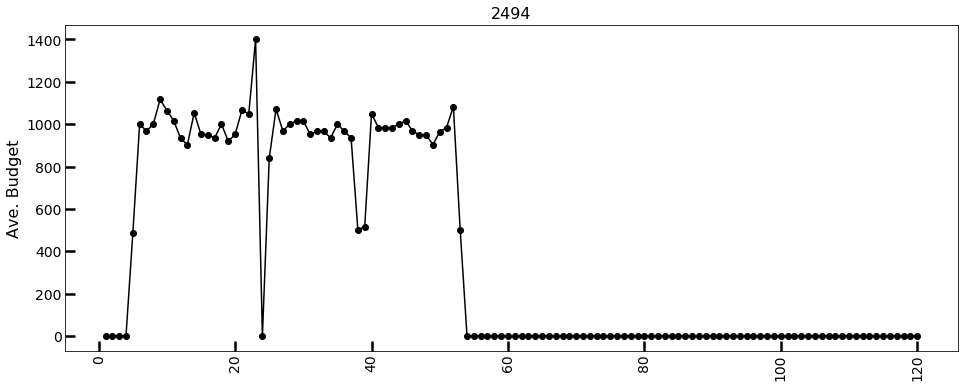

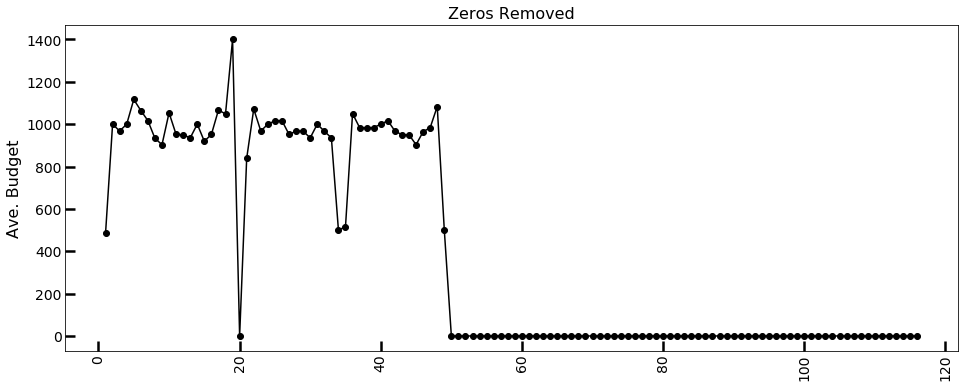

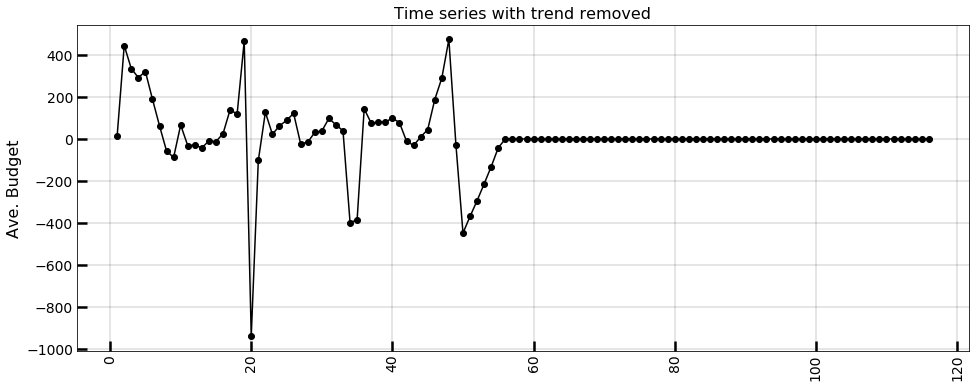

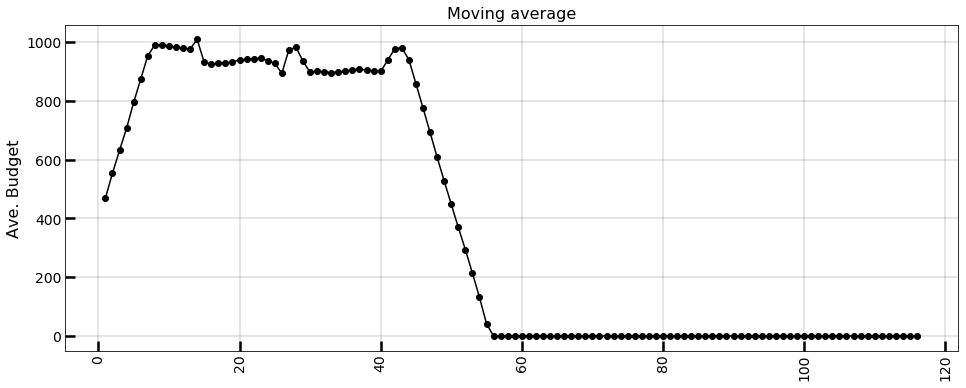

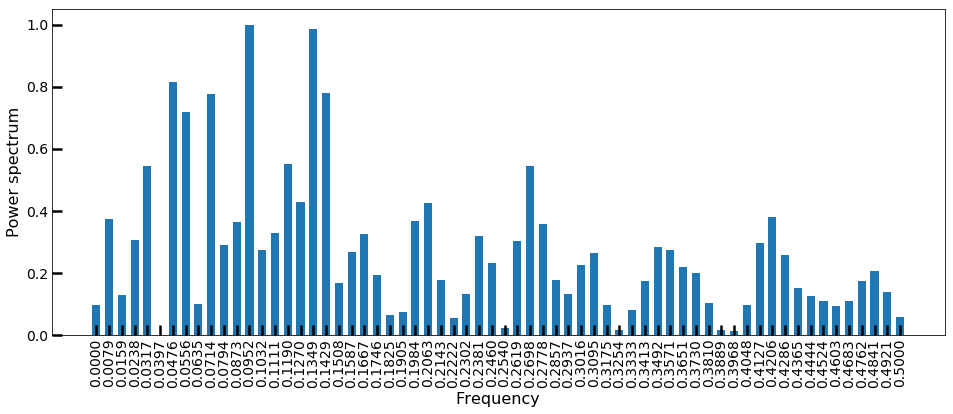

In [43]:
location=101

#print('Seasonality detected:', seasonal[location])
#print('Period detected:', my_periods[location])

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,df.columns.shape[0]+1), df.iloc[location,:],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title(df.index[location], fontsize=16);

time_series=np.array(df.iloc[location,:]).reshape(1,-1)
index=(time_series != 0).argmax()
time_series=time_series[0][index:].reshape(1,-1)


plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,len(time_series[0])+1), time_series[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Zeros Removed', fontsize=16);

mov_avg=ma(time_series, window=12)
time_series=time_series-ma(time_series, window=12)
nfft=1<<(time_series.shape[1]-1).bit_length()
freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
freq_ts=freq_ts.reshape(1,-1).T


# Perform FFT
y=np.fft.fft(time_series, n=nfft)
y=abs(y**2) # Get the power spectrum

# Scale (optional)
y=(y-y.min())
y=y/y.max()

# Reshaping because Python is stupid and doesn't take care of this 
# automatically. Boy I miss Matlab.
y=y[0][0:int(nfft/2)].reshape(1,-1).T

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,len(time_series[0])+1),time_series[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time series with trend removed', fontsize=16)
 

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,len(mov_avg[0])+1),mov_avg[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Moving average', fontsize=16)

plt.figure(figsize=(16,6))
plt.cla()
plt.bar(freq_ts.T[0],y.T[0], width=0.005)
plt.xticks(ticks=freq_ts.T[0], rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);


#print( (1/freq_ts[ np.argmax(y) ])[0] )

In [44]:
outs_TEST=get_periods_and_anomaly_TEST2(df, 12, 0.8, location)

In [45]:
print('Period= ',outs_TEST[0])
print('Flags= ', outs_TEST[1])
freqqq=outs_TEST[2]
yyy=outs_TEST[3]
ttts=outs_TEST[4]
nooo=outs_TEST[5]
holddd=outs_TEST[6]

Period=  [7]
Flags=  [[47]]


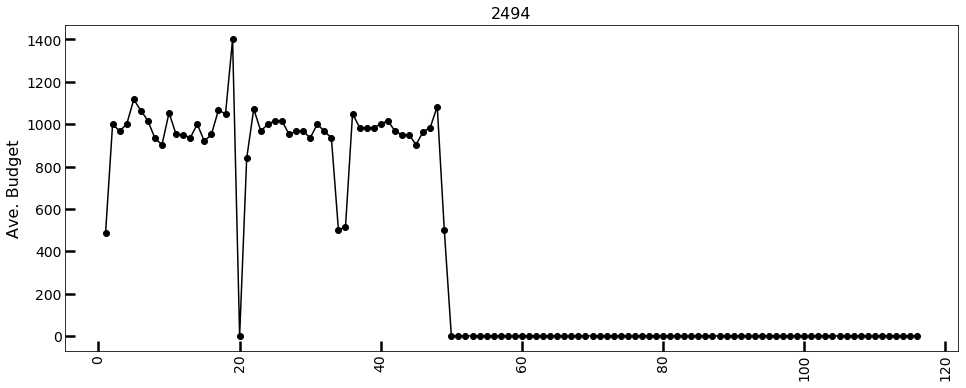

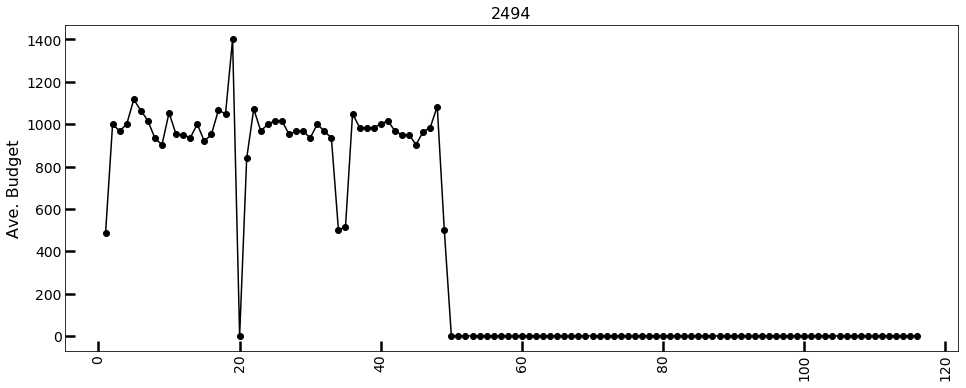

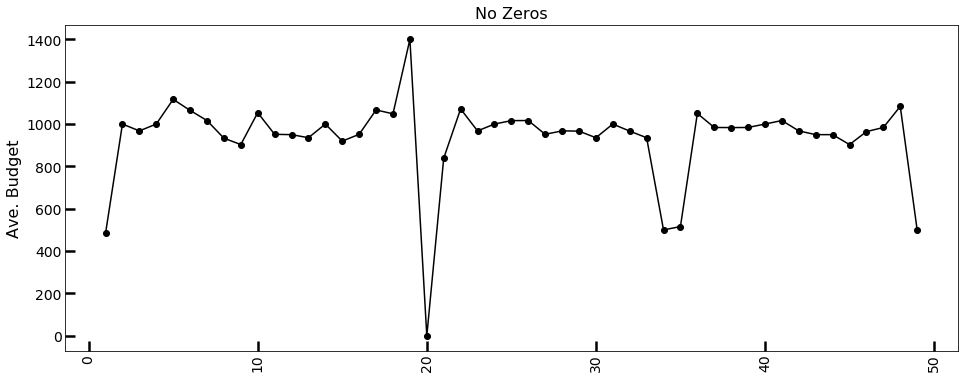

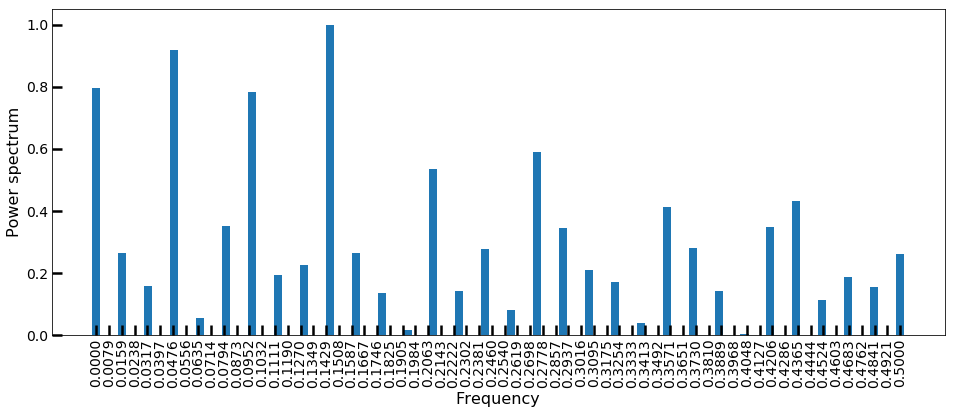

In [46]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,ttts.shape[1]+1), ttts[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title(df.index[location], fontsize=16);

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,holddd.shape[1]+1), holddd[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title(df.index[location], fontsize=16);

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,nooo.shape[1]+1), nooo[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('No Zeros', fontsize=16);

plt.figure(figsize=(16,6))
plt.cla()
plt.bar(freqqq.T[0],yyy.T[0], width=0.005)
plt.xticks(ticks=freq_ts.T[0], rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);

In [14]:
ttts[0]=ttts[0][::-1]

In [15]:
time_series=np.array(df.iloc[location,:]).reshape(1,-1)

# Remove heading zeros
index=(time_series != 0).argmax()
time_series=time_series[0][index::].reshape(1,-1)

hold_itz=time_series

# time_series[0]=time_series[0][::-1]
# index=(time_series != 0).argmax()
# time_series=time_series[0][index:].reshape(1,-1)
# time_series[0]=time_series[0][::-1]

In [16]:
time_series

array([[ 483.87096774, 1000.        ,  967.74193548, 1000.        ,
        1116.66666667, 1064.51612903, 1016.66666667,  933.33333333,
         903.22580645, 1053.57142857,  951.61290323,  950.        ,
         935.48387097, 1000.        ,  919.35483871,  951.61290323,
        1066.66666667, 1048.38709677, 1400.        ,    0.        ,
         838.70967742, 1071.42857143,  967.74193548, 1000.        ,
        1016.12903226, 1016.66666667,  951.61290323,  967.74193548,
         966.66666667,  935.48387097, 1000.        ,  966.66666667,
         935.48387097,  500.        ,  516.12903226, 1050.        ,
         983.87096774,  983.33333333,  983.87096774, 1000.        ,
        1016.66666667,  967.74193548,  950.        ,  950.        ,
         903.22580645,  964.28571429,  983.87096774, 1083.33333333,
         500.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.     

In [17]:
hold_itz

array([[ 483.87096774, 1000.        ,  967.74193548, 1000.        ,
        1116.66666667, 1064.51612903, 1016.66666667,  933.33333333,
         903.22580645, 1053.57142857,  951.61290323,  950.        ,
         935.48387097, 1000.        ,  919.35483871,  951.61290323,
        1066.66666667, 1048.38709677, 1400.        ,    0.        ,
         838.70967742, 1071.42857143,  967.74193548, 1000.        ,
        1016.12903226, 1016.66666667,  951.61290323,  967.74193548,
         966.66666667,  935.48387097, 1000.        ,  966.66666667,
         935.48387097,  500.        ,  516.12903226, 1050.        ,
         983.87096774,  983.33333333,  983.87096774, 1000.        ,
        1016.66666667,  967.74193548,  950.        ,  950.        ,
         903.22580645,  964.28571429,  983.87096774, 1083.33333333,
         500.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.     

In [18]:
time_series[0]=time_series[0][::-1]
index=(time_series != 0).argmax()
time_series=time_series[0][index:].reshape(1,-1)
time_series[0]=time_series[0][::-1]

In [19]:
time_series

array([[ 483.87096774, 1000.        ,  967.74193548, 1000.        ,
        1116.66666667, 1064.51612903, 1016.66666667,  933.33333333,
         903.22580645, 1053.57142857,  951.61290323,  950.        ,
         935.48387097, 1000.        ,  919.35483871,  951.61290323,
        1066.66666667, 1048.38709677, 1400.        ,    0.        ,
         838.70967742, 1071.42857143,  967.74193548, 1000.        ,
        1016.12903226, 1016.66666667,  951.61290323,  967.74193548,
         966.66666667,  935.48387097, 1000.        ,  966.66666667,
         935.48387097,  500.        ,  516.12903226, 1050.        ,
         983.87096774,  983.33333333,  983.87096774, 1000.        ,
        1016.66666667,  967.74193548,  950.        ,  950.        ,
         903.22580645,  964.28571429,  983.87096774, 1083.33333333,
         500.        ]])

In [20]:
hold_itz

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.     

In [38]:
wtf=[0,0,0,0,0,0,0,1,2,3,4,5,6,7,8,9,0,0,0,0,0,0,0,0,0,0,0]
my_wtf=np.array(wtf).reshape(1,-1)

# Remove heading zeros
index=(my_wtf != 0).argmax()
my_wtf=my_wtf[0][index::].reshape(1,-1)

print(my_wtf)

hold_it=my_wtf.copy()

print(hold_it)

my_wtf[0][-1]=999

# my_wtf[0]=my_wtf[0][::-1]
# index=(my_wtf != 0).argmax()
# my_wtf=my_wtf[0][index:].reshape(1,-1)
# my_wtf[0]=my_wtf[0][::-1]

[[1 2 3 4 5 6 7 8 9 0 0 0 0 0 0 0 0 0 0 0]]
[[1 2 3 4 5 6 7 8 9 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
my_wtf.shape

(1, 20)

In [40]:
my_wtf

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 999]])

In [41]:
hold_it

array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])